In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os 
import numpy as np
import torch
import datetime
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from collections import OrderedDict 

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#debug mode
debug=True
train_the_model=True
test_the_network=True
display_on_console=False
confusion_matrix_on=True
find_std_and_mean=False

n_epochs = 40
# define dataloader parameters
#get the batch size so that the test and training sets are correctly sliced
batch_size = 20
num_workers=0
name_of_csv="Results_of_classification_5_new.csv"
path_to_save='5_new_model_vgg19_bn_BabyCare.pth' 
check_with_non_skew=False

if check_with_non_skew==True:
    batch_size = 10

ModuleNotFoundError: No module named 'torch'

In [ ]:
#################################################
#A customized data loader which gives away paths#
#################################################

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

    

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if debug==True:
    if not train_on_gpu:
        print('CUDA is not available.  Training on CPU ...')
    else:
        print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
################################
#Loading and transformaing data#
################################

# define training and test data directories
data_dir=r'C:\Users\makerspace.im.EU\Documents\DO_NOT_DELETE_Shane_Tel_01637292488\data\sorted_images_single_label_With_augmentation\sorted_images'

train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['Lot Code', 'Other', 'Package', 'Product Defect', 'Receipt']


In [ ]:
# load and transform data using ImageFolder
#########################################################################
if find_std_and_mean==True:
    for i in range(5): 

            # VGG-16 Takes 224x224 images as input, so we resize all of them
        #torchvision.transforms.Normalize(mean, std, inplace=False)
        #input[channel] = (input[channel] - mean[channel]) / std[channel]
        
        train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                                transforms.ToTensor()])

        test_transforms = transforms.Compose([transforms.Resize(255),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor()])

        train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
        test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

        # prepare data loaders

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                             num_workers=num_workers, shuffle=False)

        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)

        pop_mean = []
        pop_std0 = []

        dataloader=train_loader
        #dataloader=test_loader  

        dataiter = iter(dataloader)
        images, labels = dataiter.next()
        numpy_image = images.numpy() # convert images to numpy for display
    
        # shape (3,)
        batch_mean = np.mean(numpy_image , axis=(0,2,3))
        batch_std0 = np.std(numpy_image, axis=(0,2,3))

        pop_mean.append(batch_mean)  #divid because totensor always makes 0..1 from 0..255
        pop_std0.append(batch_std0)

        # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)

        pop_mean = np.array(pop_mean).mean(axis=0)
        pop_std0 = np.array(pop_std0).mean(axis=0)    
        print("Mean :{} std div:{} ".format(pop_mean,pop_std0))
########################################################################
else:
    # percentage of training set to use as validation
    valid_size = 0.2

    # VGG-16 Takes 224x224 images as input, so we resize all of them
    train_transforms = transforms.Compose([transforms.RandomRotation(40),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                           transforms.Normalize([0.425, 0.48, 0.53],
                                                                [0.247, 0.215, 0.226])])
    test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.425, 0.48, 0.53],
                                                                [0.247, 0.215, 0.226])])


    train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
    test_data = ImageFolderWithPaths(test_dir, transform=test_transforms)


    percentage_train_data= round((len(train_data)*100/len(train_data+test_data)))
    percentage_test_data=round((len(test_data)*100/len(train_data+test_data)))
    # print out some data stats
    print('Num training images: {} among {} batches.|| {}% out of Total Images'.format(len(train_data),len(train_data)/batch_size,percentage_train_data) )
    print('Num test images: {} among {} batches. || {}% out of Total Images'.format(len(test_data),len(test_data)/batch_size,percentage_test_data) )

Num training images: 19757 among 987.85 batches.|| 85% out of Total Images
Num test images: 3462 among 173.1 batches. || 15% out of Total Images


In [ ]:
#################################
#Prepare Dataloaders for Batches#
#################################



# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                     sampler=train_sampler,num_workers=num_workers, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                    sampler=valid_sampler, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

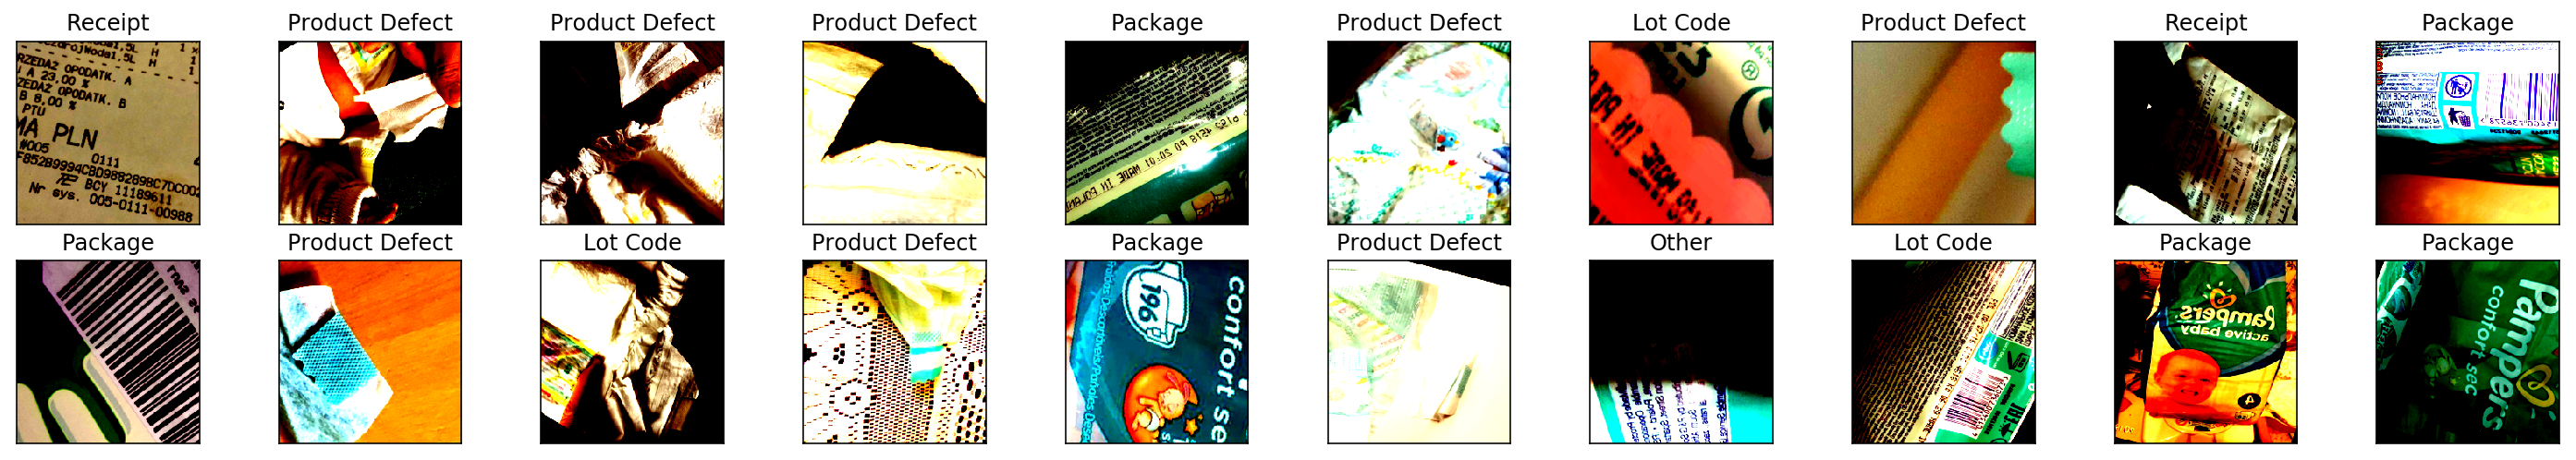

In [ ]:
# Visualize some sample data
if check_with_non_skew==False:
    # obtain one batch of training images
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    images.shape

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])



In [ ]:
#############################################################################
#Loading a trained pytorch model & locking convolution nn weights and biases#
#############################################################################

# Load the pretrained model from pytorch
model = models.vgg19_bn(pretrained=True)

# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False
    

In [ ]:
if debug==True:
    print(type(model.classifier))

<class 'torch.nn.modules.container.Sequential'>


In [ ]:
##########################################
#Defining the final fully connected layer#
##########################################

import torch.nn as nn
#****************Define multiple layers of model


# new layers automatically have requires_grad = True
last_layer = nn.Linear(4096, 512)


#****************************************************************************************
#Define an entirely new classifier..
#add a few last layers to the classifier of the model...
#model.classifier[6]=nn.Linear(4096,512,bias=True)

model.classifier=nn.Sequential(OrderedDict([
        ('Linear1',nn.Linear(in_features=25088, out_features=12000, bias=True)),
        ('relu1',nn.ReLU(inplace=True)),
        ('dropOut1',nn.Dropout(p=0.6)),
        ('Linear2',nn.Linear(in_features=12000, out_features=4096, bias=True)),
        ('relu2',nn.ReLU(inplace=True)),
        ('dropOut2',nn.Dropout(p=0.6)),
        ('Linear3',nn.Linear(in_features=4096, out_features=4096, bias=True)),
        ('relu3', nn.ReLU(inplace=True)),
        ('dropout3', nn.Dropout(p=0.5)),
        ('Linear4',nn.Linear(in_features=4096, out_features=5, bias=True)),
        ]))

# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

# check to see that your last layer produces the expected number of outputs
#print(model.classifier[6].out_features)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [ ]:
#############################
#Loss Function and Optimizer#
#############################
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent-adam) and learning rate = 0.001

optimizer = optim.SGD(model.classifier.parameters(), lr=0.001,momentum=0.8 )

In [ ]:
##############################
#Train and Validate the Model#
##############################
  

if train_the_model==True:
    # number of epochs to train the model
    

    valid_loss_min = np.Inf # track change in validation loss
    training_loss_array=[]
    valid_loss_array=[]
    
    Start_time=(datetime.datetime.now())
    print('Start: {}'.format(Start_time))

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()  

        print('Training done.. Validating....')
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()#*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

        # print training/validation statistics 
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,n_epochs, train_loss, valid_loss))
        #append data into arrays for plotting later.
        valid_loss_array.append(valid_loss)
        training_loss_array.append(train_loss)

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), path_to_save)
            valid_loss_min = valid_loss

    End_time=(datetime.datetime.now())
    print('End: {}'.format(End_time))
    print('Time taken for training: {}'.format(End_time-Start_time))

Start: 2019-07-25 18:04:48.854474
Training done.. Validating....
Epoch: 1/40 	Training Loss: 0.054779 	Validation Loss: 0.011136
Validation loss decreased (inf --> 0.011136).  Saving model ...
Training done.. Validating....
Epoch: 2/40 	Training Loss: 0.040698 	Validation Loss: 0.009015
Validation loss decreased (0.011136 --> 0.009015).  Saving model ...
Training done.. Validating....
Epoch: 3/40 	Training Loss: 0.034328 	Validation Loss: 0.007678
Validation loss decreased (0.009015 --> 0.007678).  Saving model ...
Training done.. Validating....
Epoch: 4/40 	Training Loss: 0.031004 	Validation Loss: 0.007001
Validation loss decreased (0.007678 --> 0.007001).  Saving model ...
Training done.. Validating....
Epoch: 5/40 	Training Loss: 0.029441 	Validation Loss: 0.007089
Training done.. Validating....
Epoch: 6/40 	Training Loss: 0.027903 	Validation Loss: 0.006449
Validation loss decreased (0.007001 --> 0.006449).  Saving model ...
Training done.. Validating....
Epoch: 7/40 	Training Los

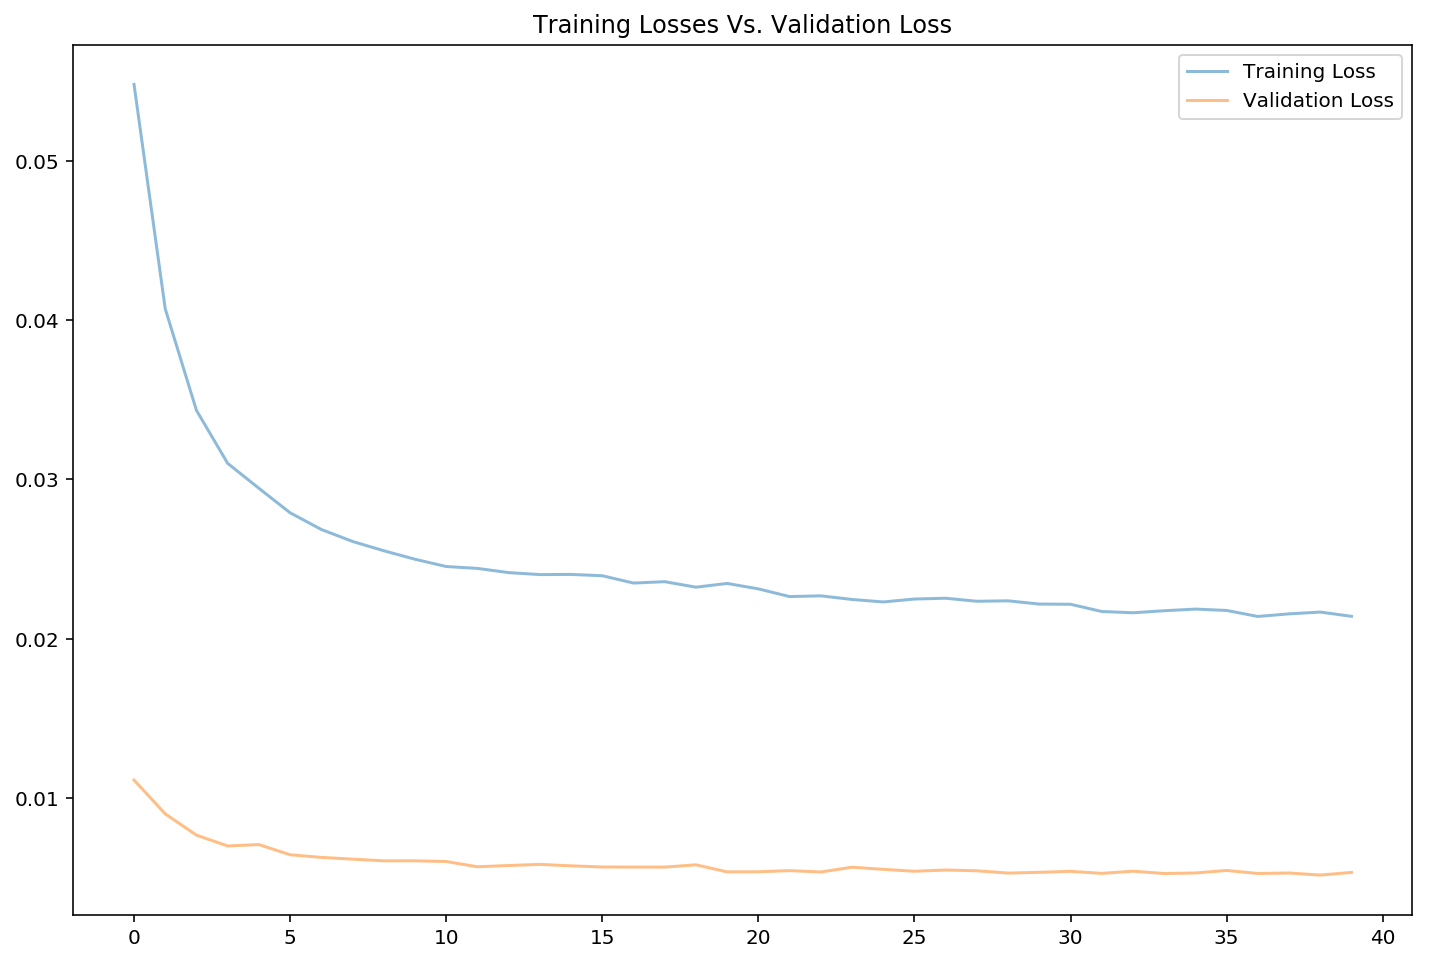

In [ ]:
if train_the_model==True:
    #Plot the Validation loss Vs Training loss.. 

    fig, ax = plt.subplots(figsize=(12,8))

    plt.plot(training_loss_array, label='Training Loss', alpha=0.5)
    plt.plot(valid_loss_array, label='Validation Loss', alpha=0.5)
    plt.title("Training Losses Vs. Validation Loss")
    plt.legend()

In [ ]:
model.load_state_dict(torch.load(path_to_save), strict=False)

print(model.state_dict().keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 

In [ ]:

##########################
#Test the trained Network#
##########################
total_preds=np.array([])
total_labels=np.array([])

if test_the_network==True:
    # track test loss 
    # over 5  classes
    test_loss = 0.0
    class_correct = list(0. for i in range(5))
    class_total = list(0. for i in range(5))

    batch_number=0

    model.eval() # evaluation mode

    if debug==True:
        print('----------- Debugging mode On -----------')
    if check_with_non_skew==True:
        print("******These are accuracies for non-skewed classes******")
    # iterate over test data
    for batch_number, (data, target,path) in enumerate(test_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        #debug step --- print('The output:{}'.format(output.shape))
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 

        ###########################################################################################
        #for debugging
        if debug==True:        
            print('Validating--> Batch number: {} with {} input images...'.format(batch_number,pred.shape[0]))


        ##########################################################################################

        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(pred.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(5):
        print('Test Accuracy of %5s class is: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))


    print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))


----------- Debugging mode On -----------
Validating--> Batch number: 0 with 20 input images...
Validating--> Batch number: 1 with 20 input images...
Validating--> Batch number: 2 with 20 input images...
Validating--> Batch number: 3 with 20 input images...
Validating--> Batch number: 4 with 20 input images...
Validating--> Batch number: 5 with 20 input images...
Validating--> Batch number: 6 with 20 input images...
Validating--> Batch number: 7 with 20 input images...
Validating--> Batch number: 8 with 20 input images...
Validating--> Batch number: 9 with 20 input images...
Validating--> Batch number: 10 with 20 input images...
Validating--> Batch number: 11 with 20 input images...
Validating--> Batch number: 12 with 20 input images...
Validating--> Batch number: 13 with 20 input images...
Validating--> Batch number: 14 with 20 input images...
Validating--> Batch number: 15 with 20 input images...
Validating--> Batch number: 16 with 20 input images...
Validating--> Batch number: 17 wi

In [ ]:
#######################
#Visualzing the sample#
#######################

############################################################
#CSV File - Predicted catergory/Actual Catergory/Image Path#
############################################################

#A dataframe with specific headings...
df = pd.DataFrame(columns=['Predicted Class','Actual Class','Correctly Classified','Path'])
no_of_batches=int(len(test_data)/batch_size)
no_rows=4
total_preds=np.array([])
total_actual_labels=np.array([])

#supress numpy warning
np.warnings.filterwarnings('ignore')

for i in range(no_of_batches):
    #sub dataframe
    sub_df = pd.DataFrame(columns=['Predicted Class','Actual Class','Correctly Classified','Path'])
    
    # obtain one batch of test images.
    # The Training dataloader will be loaded by my customs loader 
    #for image paths.
    dataiter = iter(test_loader)
    images, labels, paths = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(80, 80))
    for idx in np.arange(len(preds)):
        if display_on_console==True:
            
            #plot and display 
            ax = fig.add_subplot(no_rows, batch_size//no_rows, idx+1, xticks=[], yticks=[])
            plt.imshow(np.transpose(images.cpu()[idx], (1, 2, 0)))
            #ax.set_title('{}'.format(paths[idx]), fontdict={'fontsize':35})
            ax.set_title("P-{} (C-{})".format(classes[preds[idx]], classes[labels[idx]]),fontdict={'fontsize':35},
                         color=("green" if preds[idx]==labels[idx].item() else "red"))
        
        #write to the CSV file
        sub_df.loc[idx,'Predicted Class'] = classes[preds[idx]]
        sub_df.loc[idx,'Actual Class']=classes[labels[idx]]
        sub_df.loc[idx,'Path']= paths[idx]
        if preds[idx]==labels[idx].item():
            sub_df.loc[idx,'Correctly Classified']= 'Correct'
        else:
            sub_df.loc[idx,'Correctly Classified']= 'Incorrect'
    if debug==True:
        print('Test {}'.format(idx))
    #append sub_df to the main df
    df=df.append(sub_df, ignore_index=True)
    
    #make multiclass confusion matrix
    if confusion_matrix_on==True:
        total_preds=np.append(total_preds,preds)
        total_actual_labels=np.append(total_actual_labels,labels)

#saves the processed data to data.csv file
df.to_csv(name_of_csv, sep='\t',index=False,  encoding='latin-1')    
print('***Done & CSV File Generated***')


Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19
Test 19


<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

<Figure size 5760x5760 with 0 Axes>

In [ ]:
total_actual_labels

array([3., 3., 2., ..., 2., 0., 3.])

In [ ]:
len(total_actual_labels)

3460

In [ ]:
total_preds

array([3., 3., 2., ..., 1., 0., 3.])

In [ ]:
preds_tensor

tensor([1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 2, 3, 0, 1, 0, 3],
       device='cuda:0')

0--> Lot Code
1--> Other
2--> Package
3--> Product Defect
4--> Receipt


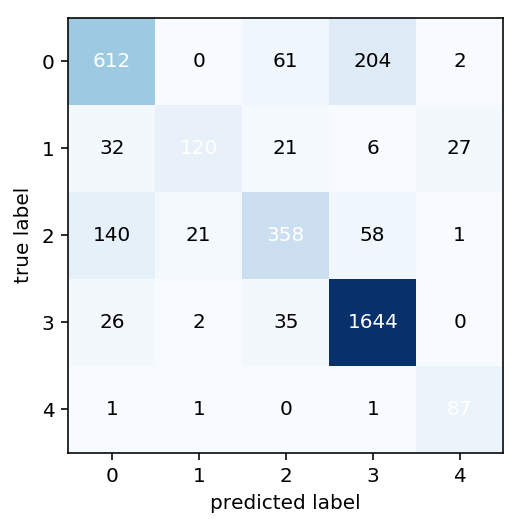

In [ ]:
confusion_matrix_on=True

#make multiclass confusion matrix
if confusion_matrix_on==True:
    cm = confusion_matrix(y_target=total_actual_labels, 
                      y_predicted=total_preds, 
                      binary=False)
    for i,name in enumerate(classes):
        print('{}--> {}'.format(i,name))
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()